<a href="https://colab.research.google.com/github/soultanyousif/cnn-and-efficientnet-on-dental-dataset/blob/main/cnn_and_efficientnet_on_dental_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/208.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/45.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/56.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/89.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/20.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/212.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/239.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/58.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/150.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/6.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/109.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/149.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/187.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/76.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/71.jpg
/kaggle/input/teeth-dataset/Tooth dataset/Mouth Ulcer/182.jpg
/kaggle/input/tee

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
base_path = '/kaggle/input/teeth-dataset/Tooth dataset'
classes = ['Calculus', 'caries', 'hypodontia', 'Mouth Ulcer', 'Tooth Discoloration']

print(classes)

2025-12-17 15:41:37.483994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765986097.901105      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765986098.015846      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765986099.078029      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765986099.078075      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765986099.078077      55 computation_placer.cc:177] computation placer alr

['Calculus', 'caries', 'hypodontia', 'Mouth Ulcer', 'Tooth Discoloration']


In [ ]:
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    class_path = os.path.join(base_path, cls)
    if os.path.exists(class_path):
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split data
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.3, random_state=42, stratify=labels
)
X_val_paths, X_test_paths, y_val, y_test = train_test_split(
    X_temp_paths, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Cap maximum weight to 3.0
max_weight = 3.0
class_weights = np.clip(class_weights, 1.0, max_weight)
class_weight_dict = dict(enumerate(class_weights))

print("Adjusted Class Weights (capped at 3.0):")
for i, cls in enumerate(classes):
    print(f"{cls}: {class_weight_dict[i]:.2f}")

Adjusted Class Weights (capped at 3.0):
Calculus: 1.00
caries: 3.00
hypodontia: 1.00
Mouth Ulcer: 3.00
Tooth Discoloration: 1.00


In [ ]:
def evaluate_model(model, test_dataset, y_true, model_name):
    print(f"Evaluating {model_name}")

    # Get predictions
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy, y_pred



In [ ]:
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

#  **CNN MODEL**

In [ ]:
def load_and_preprocess_image(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_saturation(img, 0.9, 1.1)

    img = img / 255.0  # Normalize to [0,1]
    return img, label

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
train_dataset = train_dataset.map(
    lambda x, y: load_and_preprocess_image(x, y, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
val_dataset = val_dataset.map(
    lambda x, y: load_and_preprocess_image(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test))
test_dataset = test_dataset.map(
    lambda x, y: load_and_preprocess_image(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1765986183.349643      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765986183.353564      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011150794..1.017174].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0250528].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0131602].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016179522..1.0036079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.026871385..1.0472108].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0187688].


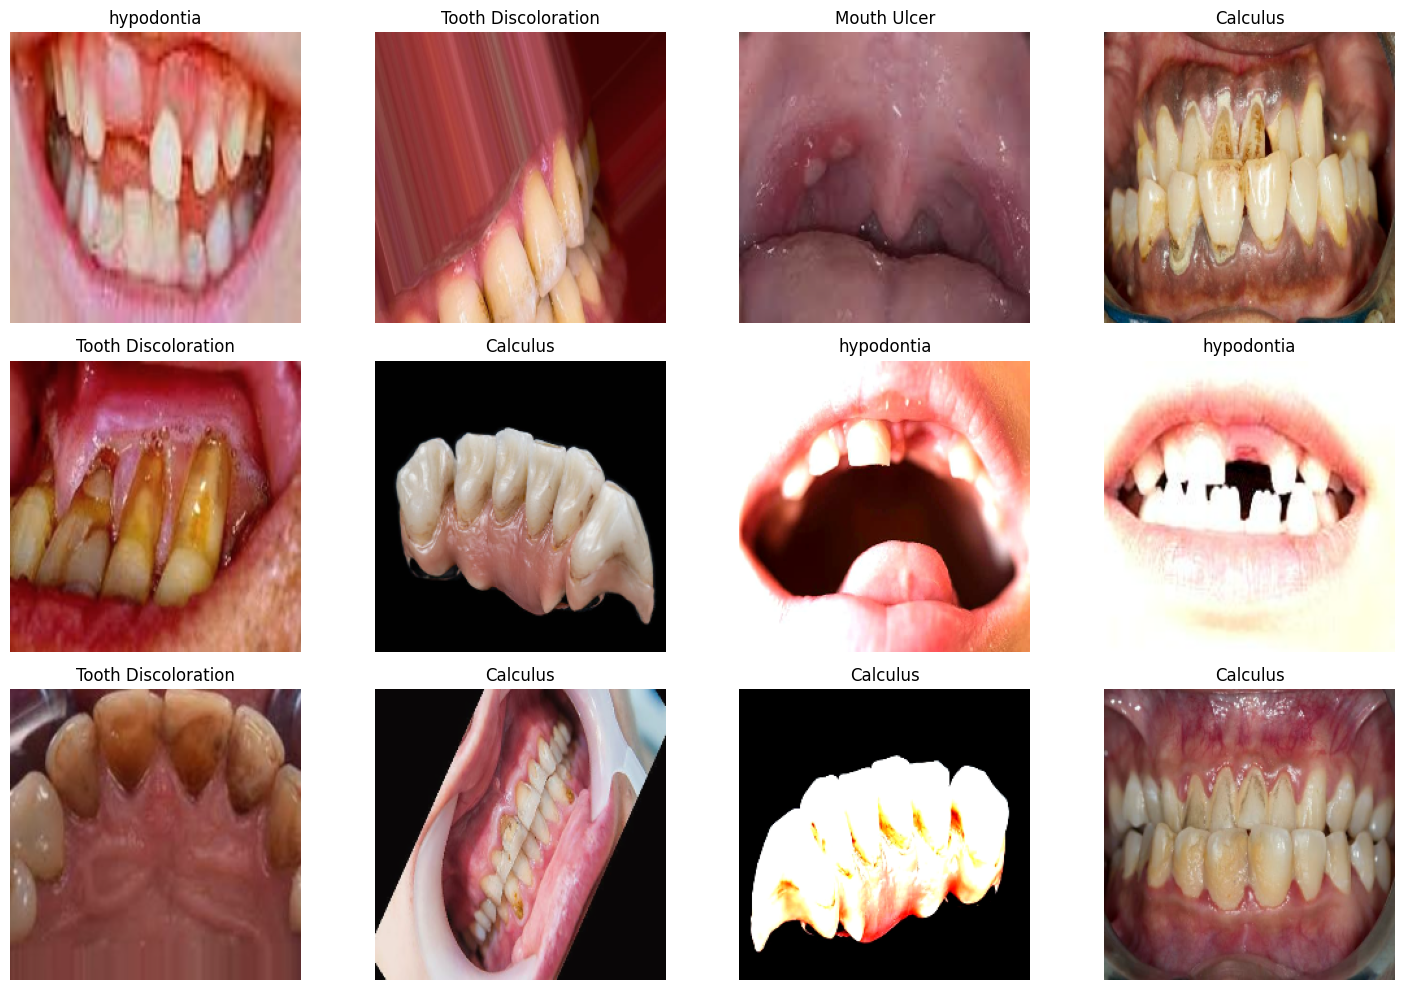

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for images, labels_batch in train_dataset.take(1):
    for i in range(min(12, len(images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(classes[labels_batch[i]])
        plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def build_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=5):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Classifier - Simplified
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Build model
cnn_model = build_cnn_model(num_classes=len(classes))

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1,
        min_delta=0.001
    ),
    ModelCheckpoint(
        'best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]
cnn_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 653,093 (2.49 MB)

 Trainable params: 651,173 (2.48 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
cnn_history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=cnn_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/100


I0000 00:00:1765986260.812740     129 service.cc:152] XLA service 0x7ed9fc00cc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765986260.812786     129 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765986260.812791     129 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765986261.999881     129 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-17 15:44:28.261331: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 15:44:28.415576: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 15:44:31.167333: E external/local_xl

110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4508 - loss: 4.5024

2025-12-17 15:45:01.653914: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 15:45:01.803018: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 15:45:03.194223: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 15:45:03.472997: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.4513 - loss: 4.4999
Epoch 1: val_accuracy improved from -inf to 0.39894, saving model to best_cnn_model.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 65s 339ms/step - accuracy: 0.4518 - loss: 4.4974 - val_accuracy: 0.3989 - val_loss: 4.9166 - learning_rate: 5.0000e-04
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5942 - loss: 3.7460
Epoch 2: val_accuracy did not improve from 0.39894
111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.5944 - loss: 3.7449 - val_accuracy: 0.3989 - val_loss: 6.0700 - learning_rate: 5.0000e-04
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6481 - loss: 3.3312
Epoch 3: val_accuracy did not improve from 0.39894
111/111 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.6483 - loss: 3.3302 - val_accuracy: 0.3989 - val_loss: 5.3896 - learning_rate: 5.0000e-04
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6979 - loss: 2.8561
Epoch 4: val_accurac

# **Evaluate CNN Model**

Evaluating CNN Model
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step

Test Accuracy: 0.9380

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.96      0.93      0.94       195
             caries       0.69      0.67      0.68        33
         hypodontia       0.98      0.94      0.96       187
        Mouth Ulcer       0.83      0.88      0.85        40
Tooth Discoloration       0.94      0.98      0.96       303

           accuracy                           0.94       758
          macro avg       0.88      0.88      0.88       758
       weighted avg       0.94      0.94      0.94       758



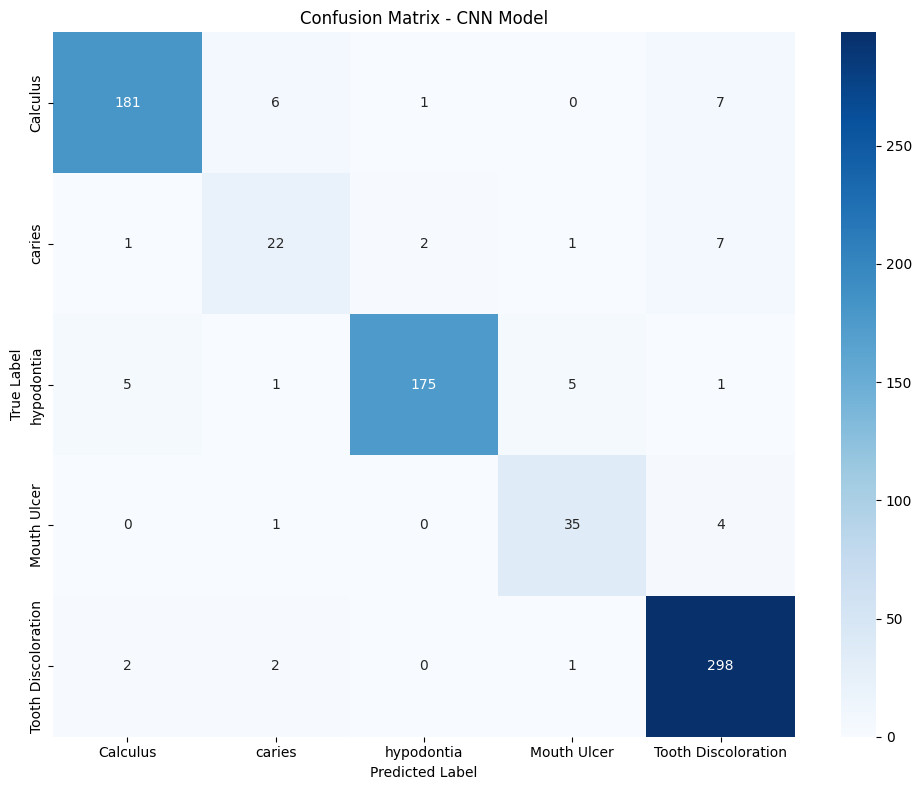

In [ ]:
cnn_accuracy, cnn_predictions = evaluate_model(cnn_model, test_dataset, y_test, "CNN Model")

# **Pretrained model**

In [ ]:
def load_and_preprocess_image_efficientnet(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        img = tf.image.random_saturation(img, 0.9, 1.1)

    # (ImageNet normalization)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, label

# Create datasets
train_dataset_eff = tf.data.Dataset.from_tensor_slices((X_train_paths, y_train))
train_dataset_eff = train_dataset_eff.map(
    lambda x, y: load_and_preprocess_image_efficientnet(x, y, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset_eff = train_dataset_eff.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset_eff = tf.data.Dataset.from_tensor_slices((X_val_paths, y_val))
val_dataset_eff = val_dataset_eff.map(
    lambda x, y: load_and_preprocess_image_efficientnet(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
val_dataset_eff = val_dataset_eff.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset_eff = tf.data.Dataset.from_tensor_slices((X_test_paths, y_test))
test_dataset_eff = test_dataset_eff.map(
    lambda x, y: load_and_preprocess_image_efficientnet(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset_eff = test_dataset_eff.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
def build_pretrained_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=5):
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze base model initially
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    return model, base_model

pretrained_model, base_model = build_pretrained_model(num_classes=len(classes))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# PHASE 1: Train classifier head with a higher learning rate
pretrained_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

pretrained_callbacks_p1 = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_pretrained_p1.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
]

print("Phase 1: Training classifier head")
history_1 = pretrained_model.fit(
    train_dataset_eff,
    validation_data=val_dataset_eff,
    epochs=50,
    callbacks=pretrained_callbacks_p1,
    class_weight=class_weight_dict,
    verbose=1
)

base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

pretrained_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

finetuning_callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_pretrained_p2.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
]

print("Phase 2: Fine-tuning model")
history_2 = pretrained_model.fit(
    train_dataset_eff,
    validation_data=val_dataset_eff,
    epochs=80,
    callbacks=finetuning_callbacks,
    class_weight=class_weight_dict,
    verbose=1
)



Phase 1: Training classifier head
Epoch 1/50


2025-12-17 16:19:55.356039: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:19:55.499394: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:19:55.847569: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:19:55.987848: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:19:56.706564: E external/local_xla/xla/stream_

110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6916 - loss: 11.1703

2025-12-17 16:20:16.010109: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:16.148713: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:16.465459: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:16.605966: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:17.318126: E external/local_xla/xla/stream_

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6926 - loss: 11.1597

2025-12-17 16:20:37.113092: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:37.254563: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:37.579325: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:37.719353: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:20:38.411609: E external/local_xla/xla/stream_


Epoch 1: val_accuracy improved from -inf to 0.92338, saving model to best_pretrained_p1.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 69s 349ms/step - accuracy: 0.6936 - loss: 11.1492 - val_accuracy: 0.9234 - val_loss: 7.8428 - learning_rate: 0.0010
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8693 - loss: 7.3042
Epoch 2: val_accuracy improved from 0.92338 to 0.93263, saving model to best_pretrained_p1.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8693 - loss: 7.2983 - val_accuracy: 0.9326 - val_loss: 5.1735 - learning_rate: 0.0010
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9139 - loss: 4.8212
Epoch 3: val_accuracy improved from 0.93263 to 0.94716, saving model to best_pretrained_p1.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9138 - loss: 4.8174 - val_accuracy: 0.9472 - val_loss: 3.4120 - learning_rate: 0.0010
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9200 - loss: 3.2225
Epoch 4: val_accuracy

# **Evaluate EfficientNetB0 Model**

Evaluating Pretrained Model (EfficientNetB0)
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

2025-12-17 16:38:29.287916: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:38:29.429367: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:38:29.758339: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:38:29.898660: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-17 16:38:30.614609: E external/local_xla/xla/stream_

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 553ms/step

Test Accuracy: 0.9776

Classification Report:
                     precision    recall  f1-score   support

           Calculus       0.96      0.98      0.97       195
             caries       0.86      0.76      0.81        33
         hypodontia       0.99      0.99      0.99       187
        Mouth Ulcer       0.97      0.95      0.96        40
Tooth Discoloration       0.99      1.00      0.99       303

           accuracy                           0.98       758
          macro avg       0.96      0.93      0.94       758
       weighted avg       0.98      0.98      0.98       758



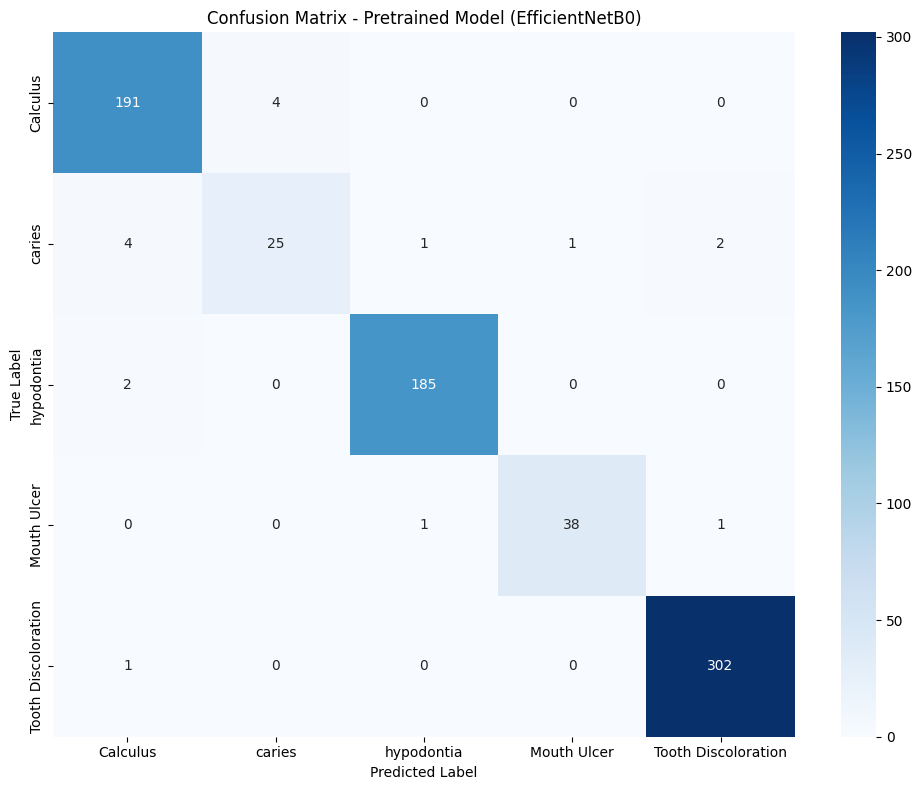

In [ ]:
pretrained_accuracy, pretrained_predictions = evaluate_model(
    pretrained_model, test_dataset_eff, y_test, "Pretrained Model (EfficientNetB0)"
)

# **history plot**

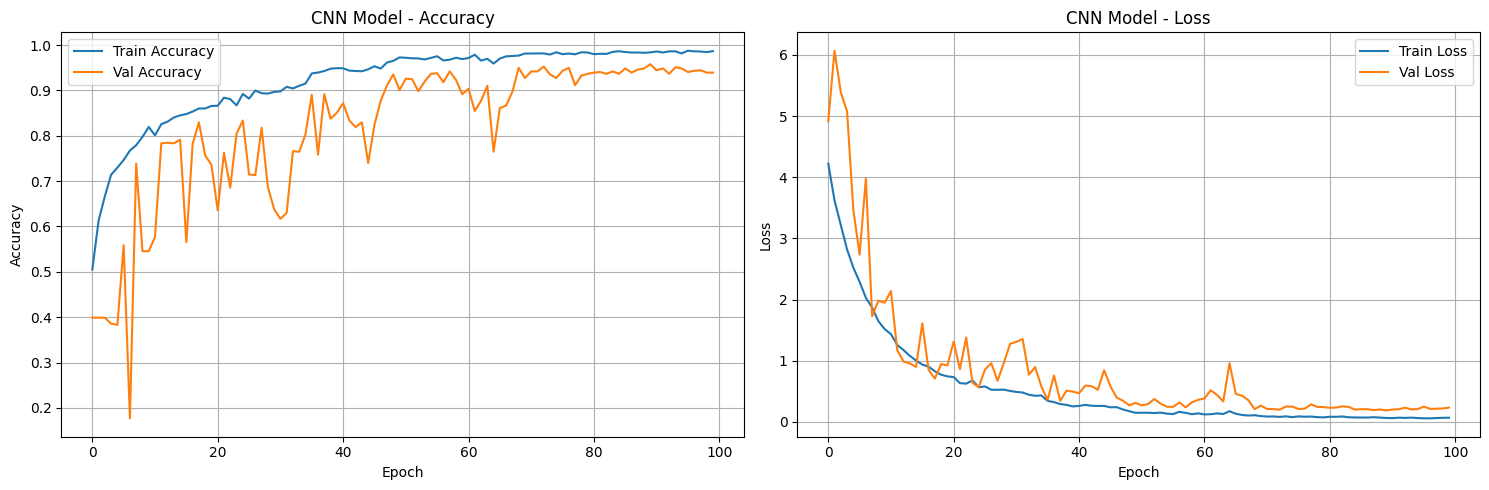

In [ ]:
plot_history(cnn_history, 'CNN Model')

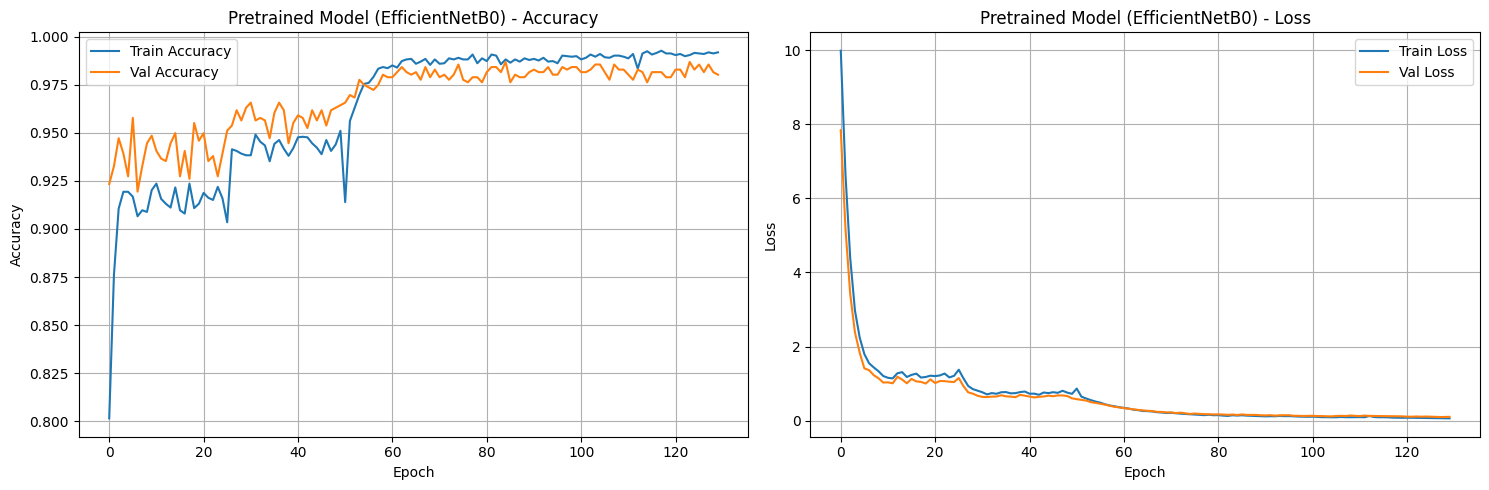

In [ ]:
combined_history = {
    'accuracy': history_1.history['accuracy'] + history_2.history['accuracy'],
    'val_accuracy': history_1.history['val_accuracy'] + history_2.history['val_accuracy'],
    'loss': history_1.history['loss'] + history_2.history['loss'],
    'val_loss': history_1.history['val_loss'] + history_2.history['val_loss']
}

class CombinedHistory:
    def __init__(self, history_dict):
        self.history = history_dict

combined = CombinedHistory(combined_history)
plot_history(combined, 'Pretrained Model (EfficientNetB0)')